# EPFD for EMI of Megaconstellations

## License
```
EPFD for EMI of Megaconstellations.
Copyright (C) 2020+  Benjamin Winkel (bwinkel@mpifr.de)
                     Federico Di Vruno (F.DiVruno@skatelescope.org)
              2020+  Gyula Józsa (gjozsa@mpifr-bonn.de)

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.
```

In [1]:
import os
from contextlib import suppress

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pycraf
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry
from astropy import units as u, constants as const
from astropy.time import Time
from tqdm import trange
from astropy.utils.misc import NumpyRNGContext
from scipy.stats import percentileofscore
import cysgp4
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry
from astropy import units as u, constants as const
from astropy.time import Time
from tqdm import trange
from astropy.utils.misc import NumpyRNGContext
from scipy.stats import percentileofscore
import cysgp4
import copy
pjoin = os.path.join

In [2]:
# Custom print command to store results in a file
def print_info(*args, **kwargs):
    infofile = kwargs.pop('infofile')
    print(*args, **kwargs)
    print(*args, **kwargs, file=infofile)
    infofile.flush()

In [3]:
def create_constellation1(
        mjd_epoch, altitudes, inclinations, sats_per_plane, rg_sats,
        raans, eccs, arg_pergs, rng_seed
        ):
    """
    Create TLEs (strings) for a set of constellations determined by 
    ndarrays

    Input:
    """
    my_sat_tles = []

    # Give the satellites numbers, starting at 80k
    sat_nr = 80000
    altitudes, inclinations, sats_per_plane, raans, eccs, arg_pergs = \
        np.broadcast_arrays(
            altitudes, inclinations, sats_per_plane, raans, eccs, 
            arg_pergs
        )
    np.random.seed(rng_seed+1)
    for alt, inc, s, rs, ecc, ap in zip(
        altitudes, inclinations, sats_per_plane, raans, eccs,
        arg_pergs
        ):
        if rg_sats:
            # distribute sats evenly in each plane
            mas = np.linspace(0.0, 360.0, s, endpoint=False)+\
                np.random.uniform(0, 360)
        else:
            # distribute sats randomly in each plane
            raans = np.random.uniform(low=0., high=360., size=s)

        # mas %= 360.
        
        # rs is one-dimensional, so the result are n x 1 arrays
        mas, rs = np.meshgrid(mas, rs)

        # Which are then flattened, so what we did here
        # was to replicate rs to the dimesion of mas
        mas, rs = mas.flatten(), rs.flatten()

        mm = cysgp4.satellite_mean_motion(alt)
        for ma, raan in zip(mas, rs):
            my_sat_tles.append(
                cysgp4.tle_linestrings_from_orbital_parameters(
                    'TEST {:d}'.format(sat_nr), sat_nr, mjd_epoch,
                    inc, raan, ecc, ap, ma, mm
                    ))
                
            sat_nr += 1
    
    return my_sat_tles

In [4]:
def randselection_sin(alpha_min, alpha_max, nnum, rng_seed):
    """Returns nnum samples in a sin number distribution"""
    i_sample = np.linspace(alpha_min, alpha_max, 100000)
    dens_raw = np.sin(np.pi*i_sample/180)
    dens_norm = dens_raw/np.sum(dens_raw)
    rng = np.random.default_rng(rng_seed+2)
    return np.random.choice(i_sample, size=nnum, p=dens_norm)

def randselection_cos(alpha_min, alpha_max, nnum, rng_seed):
    """Returns nnum samples in a sin number distribution"""
    i_sample = np.linspace(alpha_min, alpha_max, 100000)
    dens_raw = np.cos(np.pi*i_sample/180)
    dens_norm = dens_raw/np.sum(dens_raw)
    rng = np.random.default_rng(rng_seed+2)
    return rng.choice(i_sample, size=nnum, p=dens_norm)


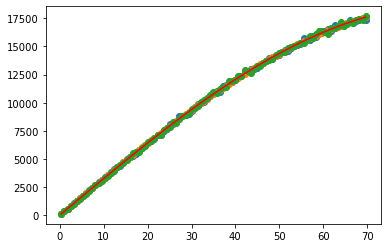

In [5]:
# Just showing how to generate a random draw 
# of angles with a density proportional to sine(angle)
if True:
    alpha_min = 0
    alpha_max = 90-20
    a = np.linspace(alpha_min, alpha_max, 100000)
    b = np.sin(np.pi*a/180)
    c = b/np.sum(b)
    d = np.random.choice(a, size=1000000, p=c)
    e = np.linspace(0,1,25)
    f = 180*np.arccos(e)/np.pi
    e = np.linspace(np.cos(np.pi*alpha_min/180.),np.cos(np.pi*alpha_max/180.),1000000)
    f = 180*np.arccos(e)/np.pi
    g = randselection_sin(alpha_min, alpha_max, 1000000, 0)
    #plt.hist(d, bins=np.linspace(0,np.pi/2,100))
    hist, bins = np.histogram(d, bins=np.linspace(alpha_min, alpha_max, 100))
    hist2, bins2 = np.histogram(f, bins=np.linspace(alpha_min, alpha_max,100))
    hist3, bins3 = np.histogram(g, bins=np.linspace(alpha_min, alpha_max,100))
    points = (bins[1:]+bins[0:-1])/2
    points2 = (bins2[1:]+bins2[0:-1])/2
    points3 = (bins3[1:]+bins3[0:-1])/2
    plt.scatter(points, hist)
    plt.scatter(points2, hist2)
    plt.scatter(points3, hist3)
    norm = np.average(hist/np.sin(np.pi*points/180))
    plt.plot(points, np.sin(np.pi*points/180)*norm, color='r')
    plt.show()

In [6]:

def get_opars(parms):
    """Create an array of tles in cysgp4 format for an artificial
    constellation. To format the constellation a limited number of
    orbital parameters can be given together with an epoch.
    The constellation is calculated under the assumption of one sat per
    orbital plane. Oribtal planes have all the same inclination and
    altitude but ascending nodes are distributed randomly. Orbits are
    circular. In case of inclination == -1 the orbital planes are
    distributed randomly on the sky (polar vectors are distributed
    randomly on the sphere.) If it is < -1 the orbits are distributed
    such that acos(i) is distributed linearly between 0 and 1.
    """
    p = parms

    # Number of planes
    nplanes = p['nplanes']

    # Bool: Random-generate planes?
    rg_planes = p['rg_planes']

    # Satellites per plane
    sats_pp = p['sats_pp']

    # Bool: random-generate 
    rg_sats = p['rg_sats']
    altitude = p['altitude']
    inclination = p['inclination']
    rng_seed = p['rng_seed']
    mjd_epoch = p['mjd_epoch']

    #print('nplanes', nplanes)
    #print('rng_seed', rng_seed)
    #print('inclination', inclination)
    #print('altitude', altitude)

    # constellation parameters
    altitudes = np.array([altitude])
    if inclination >= 0:
        inclinations = np.array([inclination])
    elif inclination == -1:
        inclinations = randselection_sin(0, 90, nplanes, rng_seed)
    elif inclination < -1:
        i_sample = np.linspace(0, 1, nplanes)
        inclinations = 180*np.arccos(i_sample)/np.pi
    
    sats_per_plane = np.array([sats_pp])
    np.random.seed(rng_seed+3)
    if rg_planes:
        raans = np.linspace(0, 360., nplanes, endpoint=False)+\
            np.random.uniform(low=0., high=360.)
    else:
        raans = np.random.uniform(low=0., high=360., size=nplanes)
    eccentricities = np.array([0.])
    arg_of_perigees = np.array([0.])

    #print('raans.shape', raans.shape)
    const_args = (
        altitudes, inclinations, sats_per_plane, rg_sats,
        raans, eccentricities, arg_of_perigees,
        rng_seed
        )
    print('a {} i {} s {} r {} ra {} e {} a {} r{}'.format(altitudes, inclinations, sats_per_plane, rg_sats,
        raans, eccentricities, arg_of_perigees,
        rng_seed))
    sats_tle_tuples = create_constellation1(mjd_epoch, *const_args)
    sats_tles = np.array([cysgp4.PyTle(*tle) for tle in sats_tle_tuples])
    return sats_tles


In [7]:
def sample_m1583(niters, low_lon, high_lon, low_lat, high_lat, rng_seed):
    ''' Return random sample of azimuths and elevations within given grid '''
    # z_low, z_high = np.cos(np.radians(90 - low_lat)), np.cos(np.radians(90 - high_lat))
    z_low, z_high = np.sin(np.radians(low_lat)), np.sin(np.radians(high_lat))
    
    np.random.seed(rng_seed+4)
    az = np.random.uniform(low_lon, high_lon, size=niters)
    el = 90 - np.degrees(np.arccos(
        np.random.uniform(z_low, z_high, size=niters)
        ))
    return az, el

def find_nearest_360(value):
    '''Find nearest divisor of 360'''
    array = np.asarray([1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 18, 20, 24,
        30, 36, 40, 45, 60, 72, 90, 120, 180])
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def sample_on_cell_grid_m1583(
        niters,
        step_size=3 * u.deg,
        lat_range=(0 * u.deg, 90 * u.deg),
        rng_seed=None,
        ):
    '''
    Returns
        array of niters times grid cells of random latitudes (niters per cell)
        array of niters times grid cells of random longitudes (niters per cell)
        7 times grid cells array with
            central lon
            central lat
            lower lon
            upper lon
            lower lat
            upper lat
            solid angle
    '''

    cell_edges, cell_mids, solid_angles, tel_az, tel_el = [], [], [], [], []
    lat_range = (lat_range[0].to_value(u.deg), lat_range[1].to_value(u.deg))
    ncells_lat = int(
        (lat_range[1] - lat_range[0]) / step_size.to_value(u.deg) + 0.5
        )
    edge_lats = np.linspace(
        lat_range[0], lat_range[1], ncells_lat + 1, endpoint=True
        )
    mid_lats = 0.5 * (edge_lats[1:] + edge_lats[:-1])
    
    step_size_corr = (lat_range[1] - lat_range[0])/ncells_lat

    with NumpyRNGContext(rng_seed):
        for low_lat, mid_lat, high_lat in zip(edge_lats[:-1], mid_lats, edge_lats[1:]):

            # The calculation below would be the most approach described in 
            # ITU-R Rec M.1583 or S.1586 in formulas
            ncells_lon = int(360 * np.cos(np.radians(mid_lat)) / step_size_corr + 0.5)

            # In the example table of ITU-R Rec M.1583 or S.1586, however, this approach is chosen,
            # to guarantee that bot ncells_lon and az_width are both integer
            # numbers:
            # az_rwidth = (lat_range[1] - lat_range[0])/(ncells_lat*np.cos(np.radians(mid_lat)))
            # ncells_lon = find_nearest_360(360/az_rwidth)
            # if mid_lat == 64.5 and step_size.to_value(u.deg) == 3.0:
            #    ncells_lon = 60

            #az_width = 360/ncells_lon

            #print('lower elevation: {} az_rwidth: {:.3f} az_step: {} ncells: {}'.format(low_lat, 
            #    az_rwidth, az_width, ncells_lon))
            edge_lons = np.linspace(0, 360, ncells_lon + 1, endpoint=True)
            mid_lons = 0.5 * (edge_lons[1:] + edge_lons[:-1])

            solid_angle = (edge_lons[1] - edge_lons[0]) * np.degrees(
                np.sin(np.radians(high_lat)) - np.sin(np.radians(low_lat))
                )
            i = 0
            for low_lon, mid_lon, high_lon in zip(edge_lons[:-1], mid_lons, edge_lons[1:]):
                cell_edges.append((low_lon, high_lon, low_lat, high_lat))
                cell_mids.append((mid_lon, mid_lat))
                solid_angles.append(solid_angle)
                cell_tel_az, cell_tel_el = sample_m1583(niters, low_lon, high_lon, low_lat, high_lat, rng_seed+i)
                tel_az.append(cell_tel_az)
                tel_el.append(cell_tel_el)

    tel_az = np.array(tel_az).T  # TODO, return u.deg
    tel_el = np.array(tel_el).T

    grid_info = np.column_stack([cell_mids, cell_edges, solid_angles])
    grid_info.dtype = np.dtype([  # TODO, return a QTable
        ('cell_lon', np.float64), ('cell_lat', np.float64),
        ('cell_lon_low', np.float64), ('cell_lon_high', np.float64),
        ('cell_lat_low', np.float64), ('cell_lat_high', np.float64), 
        ('solid_angle', np.float64), 
        ])
    return tel_az, tel_el, grid_info[:, 0]

if False:
    niters = 100
    min_lat = 0 * u.deg
    grid_size = 3 * u.deg
    rng_seed = 0
    tel_az, tel_el, grid_info = sample_on_cell_grid_m1583(
        niters,
        step_size=grid_size,
        lat_range=(min_lat, 90 * u.deg),
        rng_seed = rng_seed,
        )

Define EPFD simulation meta parameters.

In [8]:
def createpaths(figpath, datapath):
    with suppress(IOError):
        os.makedirs(figpath)

    with suppress(IOError):
        os.makedirs(datapath)


In [9]:
# Functions to define antenna patterns
def iso_pattern(zendist, diameter, frequency, efficiency):
    """
    obsolete
    """
    return 0 * cnv.dBi

def all_patterns(sat_obs_az, sat_obs_el, az_tx, el_tx, length,
    wavelength, efficiency, pattern='composite'):
    """
    Rectangular grid with edge lenght length or diameter length
    efficiency is ignored
    Notice that this is a normalised pattern, assuming that p_tx is EIRP
    """
    if length == 0:
        return 0 * cnv.dBi
    else:
        if pattern == 'composite':
            G_Emax = 5 * cnv.dB
            A_m, SLA_nu = 30. * cnv.dB, 30. * cnv.dB
            phi_3db, theta_3db = 65. * u.deg, 65. * u.deg
            d_H, d_V = 0.5 * cnv.dimless, 0.5 * cnv.dimless

            # Elements proportional to length
            N_H = round(length.to_value(u.m)/wavelength.to_value(u.m))
            N_V = N_H

            norm = pycraf.antenna.imt2020_composite_pattern(0*u.deg, 
                0*u.deg, 0*u.deg, 0*u.deg, G_Emax, A_m, SLA_nu,
                phi_3db, theta_3db, d_H, d_V, N_H, N_V)
            return (pycraf.antenna.imt2020_composite_pattern(sat_obs_az*u.deg, 
                sat_obs_el*u.deg, az_tx*u.deg, el_tx*u.deg, G_Emax, A_m, SLA_nu,
                phi_3db, theta_3db, d_H, d_V, N_H, N_V)-norm)
        else:
            angdist_tx = geometry.true_angular_distance(
                az_tx*u.deg, el_tx*u.deg,
                sat_obs_az*u.deg, sat_obs_el*u.deg)
            norm = antenna.ras_pattern(
                0*u.deg, length, wavelength, eta_a = efficiency)
            return (antenna.ras_pattern(
                angdist_tx, length, wavelength, 
                eta_a = efficiency)-norm)

def combined_ras_pattern_0(zendist, frequency, efficiency, diameter):
    if diameter == 0:
        return 0 * cnv.dBi
    else:
        return antenna.ras_pattern(
            zendist, diameter, frequency, efficiency)/antenna.ras_pattern(
                0*u.deg, diameter, frequency, efficiency)

In [10]:
def define_allpars(
    ###
    # Locations
    ###
    # Paths
    figpath = 'fig_pycraf',
    datapath = 'data_pycraf',

    ####
    # Simulation meta parameters
    ####
    rng_seed = 1,
    chunk_size = 2500,

    grid_mode = 'to', # Alternatively 'eq'
    min_lat = 0 * u.deg, # Also used for equatorial
    grid_size = 3. * u.deg,
    niters = 100,
    time_range = 2000, 
    time_resol = 1,  # seconds

    #eq_lat_range = (-40 * u.deg, 90 * u.deg),

    ####
    # Band and bandwitdh for simulation, observer
    ####
    freq = 1413.5 * u.MHz,

    # Return to Rec. ITU-R RA.769
    ras_bandwidth = 27 * u.MHz,
    #ras_bandwidth = 1 * u.MHz,
    p_lim = -205 * cnv.dB_W, # RAS threshold (received power)
    pfd_lim = -180 * cnv.dB_W_m2, # RAS threshold (pdf)
    obs_lon = 0., 
    obs_lat = 50., 
    obs_alt = 0.,  # deg, deg, km
    d_rx = 25 * u.m,  # RAS size of some antenna
    eta_a_rx = 100 * u.percent,  # RAS antenna aperture efficiency
        
    ####
    # Constellation (inclusive preparing the constellation)
    ####
    mjd_epoch = 58813.5,
    nplanes = 10,
    rg_planes = True,   # Will distribute raans regularly over 360 deg
                        # or not
    sats_pp = 10,
    rg_sats = True, # Will distribute sats regularly on plane
    altitude = 500.,
    inclination = 89.9,
    # G_tx = 0 * cnv.dBi,  # assume isotropic EMI
    d_tx = 0, # size of satellite antenna, modelled as composite ant in m
                    # 0: isotropic
    eta_a_tx = 100 * u.percent,  # satellite antenna aperture efficiency
    duty_cycle = (1 * cnv.dimless).to(u.percent),  # no duty
    activity_cycle = 1, # use this to simulate more realistic duty cycling;
    pointing_time = 200, # time in seconds for satellite pointing, must 
                        # be a multiple of time_resol and time range 
                        # must be dividable by pointing_time
    h_min = 25,  # Minimum elevation as seen by observer for boresight
                 # pointing of the satellite in degrees
    sat_gain_func = 'composite',

    #p_tx_nu_peak =(cnv.ptx_from_efield(
    #    30 * cnv.dB_uV_m, 10 * u.m, 0 * cnv.dBi
    #    ) / 120 / u.kHz).to(cnv.dBm_MHz) # CISPR-32, Class B
    # <Decibel -45.56001949 dB(mW / MHz)>

    # 1 Watt EIRP over 1 MHz
    # Starlink has -41.1 dBW/Hz = 72.44 W/MHz EIRP 
    # p_tx_nu_peak = (1.0*u.W/u.MHz) would be -60 dB(W/Hz)
    # or 30 dB()
    p_tx_nu_peak = (0.01*u.mW/u.MHz)
    ):
    return {
        'datapath': datapath,
        'figpath': figpath,

        'rng_seed': rng_seed,
        'chunk_size': chunk_size,

        'grid_mode': grid_mode,
        'min_lat': min_lat,
        'grid_size': grid_size,
        'niters': niters,
        'time_range': time_range,
        'time_resol': time_resol,
        #'eq_lat_range': eq_lat_range,

        'freq': freq,
        'ras_bandwidth': ras_bandwidth,
        'p_lim': p_lim,
        'pfd_lim': pfd_lim,
        'obs_lon': obs_lon,
        'obs_lat': obs_lat,
        'obs_alt': obs_alt,
        'd_rx': d_rx,
        'eta_a_rx': eta_a_rx,

        'mjd_epoch': mjd_epoch,
        'nplanes': nplanes,
        'rg_planes': rg_planes,
        'sats_pp': sats_pp,
        'rg_sats': rg_sats,
        'altitude': altitude,
        'inclination': inclination,
        #'G_tx': G_tx,
        'sat_gain_func': sat_gain_func,
        'd_tx': d_tx,
        'eta_a_tx': eta_a_tx,
        'duty_cycle': duty_cycle,
        'activity_cycle': activity_cycle,
        'pointing_time': pointing_time,
        'h_min': h_min,
        'p_tx_nu_peak': p_tx_nu_peak,
        'dummy': 1,
    }
# allpars = define_allpars()

In [28]:
def getnames(parms):
    
    # Update global variables with the input
    #globals().update(parms)
    p=parms

    # Names und strings
    observer_name = 'l{:.0f}'.format(p['obs_lat'])
    observer_name += '_dr{:03.0f}_f{:.0f}_{:s}'.format(p['d_rx'].to_value(u.m),
                                               p['freq'].to_value(u.MHz),
                                               p['grid_mode'])
    if p['rg_sats']:
        rgs = 'r'
    else:
        rgs = 'i'
    
    if p['rg_planes']:
        rgp = 'r'
    else:
        rgp = 'i'

    designation = 'p{:03.0f}_i{:02.0f}_n{:03d}{:s}x{:03d}{:s}_dt{:03.0f}_a{:04.0f}_c{:02d}_s{:02d}'.format(
                                                        -p['p_tx_nu_peak'].to_value(cnv.dBm_MHz)*10.,
                                                        p['inclination'], 
                                                        p['nplanes'],
                                                        rgp,
                                                        p['sats_pp'],
                                                        rgs,
                                                        p['d_tx']*10,
                                                        p['altitude'],
                                                        p['activity_cycle'],
                                                        p['rng_seed']
                                                        )
    basename = '{:s}_{:s}_emi'.format(designation, observer_name)
    if not os.path.exists(p['datapath']):
        os.makedirs(p['datapath'])
    prxfile = pjoin(p['datapath'], basename + '_hor_sim.npz')
    anafile = pjoin(p['datapath'], basename + '_hor_ana.npz')
    if not os.path.exists(p['figpath']):
        os.makedirs(p['figpath'])
    infofile = open(pjoin(p['figpath'], basename + '_info_and_results.txt'),
        'w')
    pkwar = {'infofile': infofile}
    figpath = p['figpath']

    p.update({
        'observer_name': observer_name,
        'designation': designation,
        'prxfile': prxfile,
        'anafile' : anafile,
        'infofile': infofile,
        'basename': basename,
        'pkwar': pkwar,
    })
    
    return [observer_name, designation, basename, prxfile, anafile, infofile, 
        figpath, pkwar]

In [12]:
def equatorial_to_topo_approx(lst_greenwich_deg, obs_lon, obs_lat, ra, dec):
    
    hour_angle = lst_greenwich_deg - obs_lon - ra

    azim = 180. - np.degrees(np.arctan2(
        np.sin(np.radians(-hour_angle)),
        np.sin(np.radians(obs_lat)) * np.cos(np.radians(hour_angle)) -
        np.cos(np.radians(obs_lat)) * np.tan(np.radians(dec))
        ))
    elev = np.degrees(np.arcsin(
        np.cos(np.radians(obs_lat)) * np.cos(np.radians(hour_angle)) *
        np.cos(np.radians(dec)) +
        np.sin(np.radians(obs_lat)) * np.sin(np.radians(dec))
        ))
    
    return azim, elev

    

In [13]:
def oneconst(parms, equatorial=False, regen=False, printstuff=True):

    #globals().update(parms)
    p=parms

    # Create local variables
    obs_lat = p['obs_lat']
    inclination = p['inclination']      
    nplanes = p['nplanes']
    altitude = p['altitude']
    p_tx_nu_peak = p['p_tx_nu_peak']
    duty_cycle = p['duty_cycle']
    ras_bandwidth = p['ras_bandwidth']
    freq = p['freq']
    mjd_epoch = p['mjd_epoch']
    niters = p['niters']
    time_range = p['time_range']
    time_resol = p['time_resol']
    obs_lon = p['obs_lon']
    obs_lat = p['obs_lat']
    obs_alt = p['obs_alt']
    grid_size = p['grid_size']
    min_lat = p['min_lat']
    rng_seed = p['rng_seed']
    chunk_size = p['chunk_size']
    activity_cycle = p['activity_cycle']
    d_rx = p['d_rx']
    eta_a_rx = p['eta_a_rx']
    p_lim = p['p_lim']
    #G_tx = p['G_tx']
    sat_gain_func = p['sat_gain_func']
    d_tx = p['d_tx']
    eta_a_tx = p['eta_a_tx']
    grid_mode = p['grid_mode']
    pointing_time = p['pointing_time']
    h_min = p['h_min']

    _dummy1, _dummy2, _dummy3, prxfile, _dummy5, _dummy6, _dummy7,\
        _dummy8 = getnames(p)

    # Either load or generate
    if (not regen) and os.path.isfile(prxfile):
        if printstuff:
            print('-' * 80)
            print('oneconst: Reading results')
        #print('-' * 80)
        horargs = np.load(prxfile)
        parms.update(horargs)

        tel_az = parms['tel_az']
        tel_el = parms['tel_el']
        grid_info = parms['grid_info']
        #constellation_name = parms['constellation_name']
        #observer_tname = parms['observer_tname']
        p_tx_nu_W_Hz = parms['p_tx_nu_W_Hz']
        p_tx_W = parms['p_tx_W']
        MCL_dB = parms['MCL_dB']
        FSPL_dB = parms['FSPL_dB']
        p_rx = parms['p_rx']

    else:
        if printstuff:
            print('-' * 80)
            print('oneconst: Generating results')
        #print('-' * 80)

        #p_tx_nu = p_tx_nu_peak.to(u.W / u.Hz) * duty_cycle
        p_tx_nu_W_Hz = (p_tx_nu_peak.to(u.W / u.Hz) * duty_cycle).to(u.W / u.Hz).value
        #print_info('P_tx_nu (into RAS band): {:e} {:.1f}'.format(
        #    p_tx_nu.to(u.W / u.Hz), p_tx_nu.to(cnv.dB_W_Hz)
        #    ), **pkwar)

        #p_tx = p_tx_nu.to(u.W / u.Hz) * ras_bandwidth
        p_tx_W = (p_tx_nu_W_Hz*(u.W / u.Hz) * ras_bandwidth).to(u.W).value
        #print_info('P_tx (into RAS band): {:.2e} {:.1f}'.format(
        #    p_tx.to(u.W), p_tx.to(cnv.dB_W)
        #    ), **pkwar)

        #MCL = p_tx.to_value(cnv.dB_W) - p_lim.to_value(cnv.dB_W)
        MCL_dB = ((p_tx_W*u.W).to_value(cnv.dB_W) - p_lim.to_value(cnv.dB_W))
        #print_info('MCL: {:.2f} dB'.format(MCL), **pkwar)
        #print_info('MCL: {:.2f} dB'.format(MCL_dB), **pkwar)

        #FSPL = cnv.free_space_loss(np.array(parms['altitude']).min() * u.km, freq).to(cnv.dB)
        FSPL_dB = cnv.free_space_loss(np.array(parms['altitude']).min() * u.km, freq).to(cnv.dB).value
        #print_info('Path loss (free space, lowest altitude): {:.2f} dB'.format(
        #    -FSPL.to_value(cnv.dB)
        #    ), **pkwar)
    
        ####
        # Create constellation
        ####
        sats_tles = get_opars(parms)

        ####
        # Create time grid in mjd
        ####
        start_mjd = mjd_epoch

        # start each simulation iteration at a random time, spread over a day
        np.random.seed(rng_seed)
        start_times = start_mjd + np.random.uniform(0, 1, niters)
        td = np.arange(0, time_range, time_resol) / 86400.  # 2000 s in steps of 1 s
        
        # mjds = start_times[:, np.newaxis] + td[np.newaxis, :]
        mjds = start_times[:, np.newaxis] + td[np.newaxis]
        #print('mjds.shape', mjds.shape)

        ####
        # Create observer
        ####
        ras_observer = cysgp4.PyObserver(obs_lon, obs_lat, obs_alt)

        ####
        # Simulate satellite positions of full constellation for each iteration run.
        ####
        result = cysgp4.propagate_many(  # see cysgp4 manual for details
            mjds[:, :, np.newaxis],
            sats_tles[np.newaxis, np.newaxis, :],
            ras_observer,
            do_sat_azel=True,
            sat_frame='zxy'
            )

        # 'zxy'
        #  z lies in the direction of motion,
        #  y perpendicular to the z-axis and the Earth center, x is
        #  pointing approximately towards nadir

        # 'xyz'
        #  x lies in the direction of motion,
        #  y is perpendicular to z and the Earth center, z is pointing
        #  approximately towards nadir


        #print('mjds.shape', mjds.shape, 'sats_tles.shape', sats_tles.shape)
        eci_pos = result['eci_pos']
        topo_pos = result['topo']
        sat_azel = result['sat_azel']

        eci_pos_x, eci_pos_y, eci_pos_z = \
            (eci_pos[..., i] for i in range(3))
        topo_pos_az, topo_pos_el, topo_pos_dist, _ = \
            (topo_pos[..., i] for i in range(4))

        # 'xyz'
        # The Observer positions in the (moving)
        # satellite frame are given as azimuth and polar angle in the
        # specified reference frame, and distance (az, theta, dist). az
        # is the angle between the projection of the vector towards
        # the observer onto the xy-plane and the x-axis. -180 deg < az
        # < 180 deg. theta is the angle between the normal vector and
        # the z-axis. -90 deg < theta < 90 deg.

        # sat_obs_az, sat_obs_nd, sat_obs_dist = \
        #    (sat_azel[..., i] for i in range(3))

        # 'zxy' in cysgp4.propagate_many, line 117:
        # The Observer positions in the
        # (co-moving) satellite frame are given as azimuth, elevation
        # in the specified reference frame, and distance (az, el,
        # dist). az is the angle between the projection of the vector
        # towards the Observer onto the xy-plane and the x-axis. -180
        # deg < az < 180 deg. el is the angle between the normal
        # vector and the xy-plane. -90 deg < el < 90 deg.
        # sat_obs_az, sat_obs_nd, sat_obs_dist = \
        #    (sat_azel[..., i] for i in range(3))
        sat_obs_az, sat_obs_el, sat_obs_dist = \
            (sat_azel[..., i] for i in range(3))
        print('sat_obs_el_min/max', sat_obs_el.min(), 
            sat_obs_el.max())
        print('sat_obs_az_min/max', sat_obs_az.min(), sat_obs_az.max())
        print(np.arcsin(6400/6900)*180/np.pi)

        # Random pointing directions of satellite antennas in sat_el and
        # sat_az system
        # Changing after pointing_time
        sampnum = int(time_range/pointing_time)
        satnum = topo_pos_el.shape[2]

        # Calculate min. (boresight) latitude for satellite pointing
        # Simplified calculation based on spherical earth assumption
        # as opposed to geoid
        earth_radius = 6371.
        lat_tx_max = np.arcsin((earth_radius/(altitude+earth_radius))
            *np.sin(np.pi*(.5+h_min/180.)))

        # lat_tx and lon_tx in reference, scaling with sin lat_tx
        # Notice that for these purposes th_tx is nadir distance, so
        # 'xyz' is used with theta as polar angle
        th_tx_xyz = randselection_sin(0, 90.-lat_tx_max,
            (niters, sampnum, satnum),
            rng_seed+2).repeat(
            pointing_time/time_resol, axis=1)
        az_tx_xyz = np.random.uniform(low=-180., high=180.,
            size=(niters, sampnum, satnum)).repeat(
            pointing_time/time_resol, axis=1)

        # Transform into 'zxy' system
        x_xyz = np.sin(np.pi*th_tx_xyz/180.)*np.cos(np.pi*az_tx_xyz/180.)
        y_xyz = np.sin(np.pi*th_tx_xyz/180.)*np.sin(np.pi*az_tx_xyz/180.)
        z_xyz = np.cos(np.pi*th_tx_xyz/180.)

        z_zxy = x_xyz
        y_zxy = -y_xyz
        x_zxy = z_xyz

        th_tx = 180.*np.arccos(z_zxy)/np.pi
        el_tx = 90.-th_tx
        az_tx = 180.*np.arctan2(y_zxy,x_zxy)/np.pi

        #tel_az, tel_el, grid_info = sample_on_cell_grid_m1583(
        tel_lon, tel_lat, grid_info = sample_on_cell_grid_m1583(
            niters,
            step_size=grid_size,
            lat_range=(min_lat, 90 * u.deg),
            rng_seed=rng_seed,
            )

        #print('tel_az.shape', tel_az.shape)
        #print('grid_info.shape', grid_info.shape)
        # plt.plot(tel_az[0], tel_el[0], '.')
        ####
        # EPFD calculation; stores mean received pfd for each iteration and sky cell.
        ####
        p_rx = np.zeros(tel_lon.shape, dtype=np.float64)
        #print('pr_rx', p_rx.shape)

        # doing the calculation for all iterations and sky cells at once
        # is very memory consuming; process data in chunks (of sky cells)
        nchunks = tel_lon.shape[1] // chunk_size + 1
        #print('nchunks', nchunks)

        for niter in trange(niters):
            # calculating the angular separations for every satellite is extremely
            # slow, need to apply visibility masks from the beginning...
            # note: even if min_elev is different from zero, satellites barely
            # above the horizon can contribute to cells at higher elevation
            vis_mask = topo_pos_el[niter, :, :] > 0.
            #print('vis_mask.shape', vis_mask.shape)
            
            if activity_cycle > 1:
                # only every n-th sample is active
                activity_mask = np.zeros_like(vis_mask)
                # we need to randomize, which satellites emit in which slot, to
                # avoid a "synchronized" transmission
                for s_idx in range(activity_mask.shape[1]):  # loop over all sats
                    activity_mask[np.random.randint(activity_cycle)::activity_cycle, s_idx] = True
                
                vis_mask = vis_mask & activity_mask
            
            FSPL = cnv.free_space_loss(
                sat_obs_dist[niter, vis_mask, np.newaxis] * u.km, freq
                ).to(cnv.dB)
            #print('sat_obs_dist.shape',sat_obs_dist.shape)
            #print('sat_obs_dist[niter, vis_mask, np.newaxis].shape', sat_obs_dist[niter, vis_mask, np.newaxis].shape)
            # G_tx = sat_gain_func(
            #     sat_obs_az[niter, vis_mask, np.newaxis] * u.deg,
            #     sat_obs_el[niter, vis_mask, np.newaxis] * u.deg,
            #     )
            # New

            #G_tx = sat_gain_func(
            #    angdist_tx[niter, vis_mask, np.newaxis],
            #    azdist_tx[niter, vis_mask, np.newaxis],
            #    d_tx, const.c / freq, eta_a_tx
            #    )
            G_tx = all_patterns(
                sat_obs_az[niter, vis_mask, np.newaxis],
                sat_obs_el[niter, vis_mask, np.newaxis],
                az_tx[niter, vis_mask, np.newaxis],
                el_tx[niter, vis_mask, np.newaxis],
                d_tx*u.m, const.c / freq, eta_a_tx,
                pattern=sat_gain_func
                )

            ##
            sat_pos_az = topo_pos_az[niter, vis_mask, np.newaxis]
            sat_pos_el = topo_pos_el[niter, vis_mask, np.newaxis]

            if grid_mode == 'eq':
                obstime = Time(mjds[niter], format='mjd')
                _lst_greenwich_deg = obstime.sidereal_time(
                    kind='mean', longitude='greenwich'
                    ).deg
                lst_greenwich_deg = np.repeat(
                    _lst_greenwich_deg[np.newaxis], topo_pos_az.shape[2], axis=0
                    ).T[vis_mask]
                    
                tel_az, tel_el = equatorial_to_topo_approx(
                    lst_greenwich_deg[:, np.newaxis],
                    obs_lon, obs_lat,
                    tel_lon[niter, np.newaxis, :],
                    tel_lat[niter, np.newaxis, :]
                )
            else:
                tel_az = tel_lon[niter, np.newaxis, :]
                tel_el = tel_lat[niter, np.newaxis, :]

                        
            #for chunk in range(nchunks):
            for chunk in range(1):
                #cells_sl = slice(
                #    chunk * chunk_size, 
                #    min((chunk + 1) * chunk_size, tel_az.shape[1])
                #    )
                
                #tel_az, tel_el = equatorial_to_topo_approx(
                #    lst_greenwich_deg[:, np.newaxis],
                #    obs_lon, obs_lat,
                #    tel_ra[niter, np.newaxis, cells_sl],
                #    tel_dec[niter, np.newaxis, cells_sl]
                #    )
        
                #ang_sep_topo = geometry.true_angular_distance(
                #    tel_az[niter, np.newaxis, cells_sl] * u.deg,
                #    tel_el[niter, np.newaxis, cells_sl] * u.deg,
                #    topo_pos_az[niter, vis_mask, np.newaxis] * u.deg,
                #    topo_pos_el[niter, vis_mask, np.newaxis] * u.deg,
                #    )

                # If mask is of size 0 there is no angular separation to
                # calculate, which would lead to an error
                if topo_pos_az[niter, vis_mask].shape[0] == 0:
                    #ang_sep_topo = np.ones((0,tel_az.shape[1]))
                    G_rx = np.ones((0,tel_az.shape[1]))* u.dex(1)
                else:
                    ang_sep_topo = geometry.true_angular_distance(
                        tel_az * u.deg,
                        tel_el * u.deg,
                        sat_pos_az * u.deg,
                        sat_pos_el * u.deg,
                        )
                    G_rx = antenna.ras_pattern(
                        ang_sep_topo, d_rx, const.c / freq, eta_a=eta_a_rx
                        )

                # Calculate average received power over the integration time
                p_rx[niter, :] = np.sum(
                    ((p_tx_W*u.W).to(cnv.dB_W) + G_tx + FSPL + G_rx).to_value(u.W),
                    axis=0
                    ) / mjds.shape[1] * activity_cycle
                p_rx[niter, p_rx[niter, :] == 0] = 1E-50
        
        #print('tel_az.shape',tel_az.shape)
        #print('topo_pos_el.shape',topo_pos_el.shape)
        #print('p_rx.shape',p_rx.shape)
        np.savez(
            prxfile,
            tel_az=tel_az,
            tel_el=tel_el,
            grid_info=grid_info,
            #pfd_lim_W_m2=pfd_lim.to_value(u.W / u.m ** 2),
            #frequency_ghz=freq.to_value(u.GHz),
            #constellation_name=constellation_name,
            #observer_tname= observer_tname,
            #obs_lon=obs_lon,
            #obs_lat=obs_lat,
            #obs_alt=obs_alt,
            p_tx_nu_W_Hz=p_tx_nu_W_Hz,
            p_tx_W=p_tx_W,
            MCL_dB=MCL_dB,
            FSPL_dB=FSPL_dB,
            p_rx=p_rx,
            )
        
        parms['tel_az'] = tel_az              
        parms['tel_el'] = tel_el              
        parms['grid_info'] = grid_info           
        #parms['constellation_name'] = constellation_name  
        #parms['observer_tname'] = observer_tname      
        parms['p_tx_nu_W_Hz'] = p_tx_nu_W_Hz        
        parms['p_tx_W'] = p_tx_W              
        parms['MCL_dB'] = MCL_dB              
        parms['FSPL_dB'] = FSPL_dB             
        parms['p_rx'] = p_rx
    return

In [14]:
def analyseconst(parms, regen=False, printstuff=True):
    p = parms
    _dummy1, _dummy2, _dummy3, _dummy4, anafile, _dummy6, _dummy7,\
        _dummy8 = getnames(p)
    
    #p_tx_nu_W_Hz = p['p_tx_nu_W_Hz']
    #p_tx_W = p['p_tx_W']
    #MCL_dB = p['MCL_dB']
    #FSPL_dB = p['FSPL_dB']
    # Automatic re-generation of information, for consistency
    oneconst(parms, regen = regen, printstuff=printstuff)

    p_rx = p['p_rx']
    freq = p['freq']
    pfd_lim = p['pfd_lim']
    grid_info = p['grid_info']

    if os.path.isfile(anafile) and not regen:
        if printstuff:
            print('-' * 80)
            print('analyseconst: Reading results')
        #print('-' * 80)
        anargs = np.load(anafile)
        p.update(anargs)
        pfd_lin = p['pfd_lin']
        pfd_dist = p['pfd_dist']
        pfd_dist_all = p['pfd_dist_all']        
        pfd98p = p['pfd98p']
        pfd98p_all = p['pfd98p_all']
        pfd98p_mean = p['pfd98p_mean']
        pfd98p_sigma = p['pfd98p_sigma']
        pfd_avg = p['pfd_avg_dB_W_m2']*cnv.dB_W_m2
        pfd_98p = p['pfd_98p_dB_W_m2']*cnv.dB_W_m2
        pfd_max = p['pfd_max_dB_W_m2']*cnv.dB_W_m2
        data_loss_per_cell = p['data_loss_per_cell']
        data_loss = p['data_loss_percent']*u.percent
        data_loss_per_iteration = p['data_loss_per_iteration']
        data_loss_mean = p['data_loss_mean']
        data_loss_m1s = p['data_loss_m1s']
        data_loss_median = p['data_loss_median']
        data_loss_p1s = p['data_loss_p1s']
        bad_cells = p['bad_cells']
        bad_cells_frac = p['bad_cells_frac']
        margin = p['margin']
    else:
        if printstuff:
            print('-' * 80)
            print('analyseconst: Generating results')
            #print('-' * 80)

        # calculate pfd from received power (receiver gain was already accounted for!)
        pfd = cnv.powerflux_from_prx(p_rx * u.W, freq, 0 * cnv.dBi).to(cnv.dB_W_m2)

        pfd_lin = pfd.to_value(u.W / u.m ** 2)
        #print('pfd_lin.shape', pfd_lin.shape)
        pfd_dist = (np.sort(pfd_lin) * u.W / u.m ** 2).to(cnv.dB_W_m2)
        pfd_dist_all = (np.sort(pfd_lin.flatten()) * u.W / u.m ** 2).to(cnv.dB_W_m2)

        # Global
        pfd98p = np.percentile(pfd_lin, 98., axis=1)
        pfd98p_all = np.percentile(pfd_lin, 98.)
        pfd98p_mean = np.mean(pfd98p)
        pfd98p_sigma = np.std(pfd98p, ddof=1)

        # Per cell
        pfd_avg = (np.mean(pfd_lin, axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
        pfd_98p = (np.percentile(pfd_lin, 98., axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
        pfd_max = (np.max(pfd_lin, axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
        margin = pfd_lim.to_value(cnv.dB_W_m2) - pfd_98p.to_value(cnv.dB_W_m2)

        _pfd_lim_W_m2 = pfd_lim.to_value(u.W / u.m ** 2)
        data_loss_per_cell = np.array([
            100 - percentileofscore(pl, _pfd_lim_W_m2, kind='strict')
            for pl in pfd_lin.T
            ])
        data_loss = (
            100 - percentileofscore(pfd_lin.flatten(), _pfd_lim_W_m2, kind='strict')
            ) * u.percent

        data_loss_per_iteration = np.array([
            100 - percentileofscore(pl, _pfd_lim_W_m2, kind='strict')
            for pl in pfd_lin
            ])
        data_loss_mean = np.mean(data_loss_per_iteration)
        data_loss_m1s, data_loss_median, data_loss_p1s = np.percentile(
            data_loss_per_iteration, [15.865, 50., 84.135]
            )
        bad_cells = np.count_nonzero(pfd_avg > pfd_lim)
        bad_cells_frac = bad_cells / len(grid_info)

        p['pfd_lin'] = pfd_lin
        p['pfd_dist'] = pfd_dist
        p['pfd_dist_all'] = pfd_dist_all
        p['pfd98p'] = pfd98p
        p['pfd98p_all'] = pfd98p_all
        p['pfd98p_mean'] = pfd98p_mean
        p['pfd98p_sigma'] = pfd98p_sigma
        p['pfd_avg_dB_W_m2'] = pfd_avg.to_value(cnv.dB_W_m2)                
        p['pfd_98p_dB_W_m2'] = pfd_98p.to_value(cnv.dB_W_m2)                
        p['pfd_max_dB_W_m2'] = pfd_max.to_value(cnv.dB_W_m2)                
        p['data_loss_per_cell'] = data_loss_per_cell     
        p['data_loss_percent'] = data_loss.to_value(u.percent)         
        p['data_loss_per_iteration'] = data_loss_per_iteration
        p['data_loss_mean'] = data_loss_mean         
        p['data_loss_m1s'] = data_loss_m1s          
        p['data_loss_median'] = data_loss_median       
        p['data_loss_p1s'] = data_loss_p1s          
        p['bad_cells'] = bad_cells              
        p['bad_cells_frac'] = bad_cells_frac
        p['margin'] = margin          

        np.savez(
            anafile,
            pfd_lin = p['pfd_lin'],                    
            pfd_dist = p['pfd_dist'],                    
            pfd_dist_all = p['pfd_dist_all'],                    
            pfd98p = p['pfd98p'],
            pfd98p_all = p['pfd98p_all'],
            pfd98p_mean = p['pfd98p_mean'],
            pfd98p_sigma = p['pfd98p_sigma'],
            pfd_avg_dB_W_m2 = p['pfd_avg_dB_W_m2'],
            pfd_98p_dB_W_m2 = p['pfd_98p_dB_W_m2'],
            pfd_max_dB_W_m2 = p['pfd_max_dB_W_m2'],
            data_loss_per_cell = p['data_loss_per_cell'],         
            data_loss_percent = p['data_loss_percent'],
            data_loss_per_iteration = p['data_loss_per_iteration'],    
            data_loss_mean = p['data_loss_mean'],             
            data_loss_m1s = p['data_loss_m1s'],              
            data_loss_median = p['data_loss_median'],           
            data_loss_p1s = p['data_loss_p1s'],              
            bad_cells = p['bad_cells'],                  
            bad_cells_frac = p['bad_cells_frac'],
            margin = p['margin'],
        )
    

In [15]:
def pltavpfd(pfd_avg, grid_mode, grid_info, figpath, basename, constellation_name,
    data_loss):
    plt.close()
    fig = plt.figure(figsize=(12, 4))
    val = pfd_avg.to_value(cnv.dB_W_m2)
    vmin, vmax = val.min(), val.max()
    val_norm = (val - vmin) / (vmax - vmin)
    plt.bar(
        grid_info['cell_lon_low'],
        height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
        width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
        bottom=grid_info['cell_lat_low'],
        color=plt.cm.viridis(val_norm),
        align='edge',
        )
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('PFD average / cell [dB(W/m2)]')
    plt.title('EPFD {:s} constellation: total data loss: {:.2f}'.format(
        constellation_name, data_loss
        ))
    if grid_mode == 'to':
        plt.xlabel('Azimuth [deg]')
        plt.ylabel('Elevation [deg]')
    else:
        plt.xlabel('RA [deg]')
        plt.ylabel('Dec [deg]')
    plt.xlim((0, 360))
    plt.ylim((grid_info['cell_lat_low'].min(), grid_info['cell_lat_high'].max()))
    plt.savefig(
        pjoin(figpath, '{:s}_skygrid_avg_pfd_horizontal.png'.format(basename)),
        bbox_inches='tight', dpi=100,
        )
    plt.savefig(
        pjoin(figpath, '{:s}_skygrid_avg_pfd_horizontal.pdf'.format(basename)),
        bbox_inches='tight',
        )
    plt.show()

In [16]:
def pltmargin(margin, grid_mode, grid_info, figpath, basename, constellation_name,
    data_loss, pfd_lim):
    plt.close()
    fig = plt.figure(figsize=(12, 4))
    val = margin
    vmin, vmax = val.min(), val.max()
    vmin, vmax = -5, 5
    val_norm = (val - vmin) / (vmax - vmin)
    plt.bar(
        grid_info['cell_lon_low'],
        height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
        width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
        bottom=grid_info['cell_lat_low'],
        color=plt.cm.bwr_r(val_norm),
        align='edge',
        )
    sm = plt.cm.ScalarMappable(cmap=plt.cm.bwr_r, 
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Margin w.r.t. PFD @ 98% / cell [dB(W/m2)]')
    plt.title('EPFD {:s}: RAS limit: {:.2f}'.format(
        constellation_name, pfd_lim
        ))
    if grid_mode == 'to':
        plt.xlabel('Azimuth [deg]')
        plt.ylabel('Elevation [deg]')
    else:
        plt.xlabel('RA [deg]')
        plt.ylabel('Dec [deg]')
    plt.xlim((0, 360))
    plt.ylim((grid_info['cell_lat_low'].min(), grid_info['cell_lat_high'].max()))

    plt.savefig(
        pjoin(figpath, '{:s}_skygrid_margin_wrt_98p_pfd_horizontal.png'.format(basename)),
        bbox_inches='tight', dpi=100,
        )
    plt.savefig(
        pjoin(figpath, '{:s}_skygrid_margin_wrt_98p_pfd_horizontal.pdf'.format(basename)),
        bbox_inches='tight',
        )
    plt.show()

In [17]:
def pltdataloss(data_loss_per_cell, grid_mode, grid_info, figpath, basename, constellation_name, data_loss):
    plt.close()
    fig = plt.figure(figsize=(12, 4))
    val = data_loss_per_cell
    vmin, vmax = val.min(), val.max()
    val_norm = (val - vmin) / (vmax - vmin)
    plt.bar(
        grid_info['cell_lon_low'],
        height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
        width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
        bottom=grid_info['cell_lat_low'],
        color=plt.cm.viridis(val_norm),
        align='edge',
        )
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Data loss / cell [%]')
    plt.title('EPFD {:s} constellation: total data loss: {:.2f}'.format(
        constellation_name, data_loss
        ))
    if grid_mode == 'to':
        plt.xlabel('Azimuth [deg]')
        plt.ylabel('Elevation [deg]')
    else:
        plt.xlabel('RA [deg]')
        plt.ylabel('Dec [deg]')
    plt.xlim((0, 360))
    plt.ylim((grid_info['cell_lat_low'].min(), grid_info['cell_lat_high'].max()))
    plt.savefig(
        pjoin(figpath, '{:s}_skygrid_data_loss_horizontal.png'.format(basename)),
        bbox_inches='tight', dpi=100,
        )
    plt.savefig(
        pjoin(figpath, '{:s}_skygrid_data_loss_horizontal.pdf'.format(basename)),
        bbox_inches='tight',
        )
    plt.show()

In [18]:
def pltcumu(pfd_dist, pfd_dist_all, pfd_lim, data_loss, data_loss_m1s, data_loss_p1s, pfd98p_all, pfd98p_sigma, pfd98p_mean, figpath, basename, constellation_name):
    plt.close()
    fig = plt.figure(figsize=(12, 6))
    plt.plot(
        pfd_dist.T, 100 * np.linspace(0, 1, pfd_dist.shape[1], endpoint=True),
        'b-', alpha=0.01,
        )
    plt.plot([], [], 'b-', label='CDF (individual iters)')
    plt.plot(
        pfd_dist_all[::20], 100 * np.linspace(0, 1, pfd_dist_all.size, endpoint=True)[::20],
        'k-', label='CDF (all iters)'
        )
    hline = plt.axhline(98., color='r', alpha=0.5)
    vline = plt.axvline(pfd_lim.to_value(cnv.dB_W_m2), color='r', alpha=0.5)
    plt.grid(color='0.8')
    plt.title('EPFD {:s} constellation: total data loss: {:.2f}'.format(
        constellation_name, data_loss
        ))
    plt.xlabel('PFD [dB(W/m2)]')
    plt.ylabel('Cumulative probability [%]')
    plt.legend(*plt.gca().get_legend_handles_labels())
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.text(
        xmin + 2, 95.,
        r'98%: pfd = ${0.value:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$ {0.unit}'.format(
            (pfd98p_all * u.W / u.m ** 2).to(cnv.dB_W_m2),
            np.abs(((1 + pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
            np.abs(((1 - pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
            ), color='red', ha='left', va='top',
        )
    plt.text(
        xmin + 2, 88.,
        r'$\rightarrow$ RAS margin = ${:.1f}^{{+{:.1f}}}_{{-{:.1f}}}$ dB'.format(
            pfd_lim.to_value(cnv.dB_W_m2) - (pfd98p_all * u.W / u.m ** 2).to_value(cnv.dB_W_m2),
            np.abs(((1 - pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
            np.abs(((1 + pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
            ), color='red', ha='left', va='top',
        )
    plt.text(
        pfd_lim.to_value(cnv.dB_W_m2) + 0.5, ymin + 20,
        r'RA.769 exceeded @ ${0.value:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$ {0.unit}'.format(
            100 * u.percent - data_loss,
            data_loss.to_value(u.percent) - data_loss_m1s,
            data_loss_p1s - data_loss.to_value(u.percent),
            ),
        color='red', ha='left', va='bottom', rotation=90.,
        )
    plt.savefig(
        pjoin(figpath, '{:s}_cumulative_data_loss_horizontal.png'.format(basename)),
        bbox_inches='tight', dpi=100,
        )
    plt.savefig(
        pjoin(figpath, '{:s}_cumulative_data_loss_horizontal.pdf'.format(basename)),
        bbox_inches='tight',
        )
    plt.show()

In [19]:
def outputconst(parms, regen=False, printstuff=True):
    p = parms
    _dummy1, _dummy2, basename, prxfile, anafile, infofile, figpath,\
        pkwar = getnames(p)

    # Re-generate parameters, for consistency
    analyseconst(p, regen=regen, printstuff=printstuff)

    obs_lat = p['obs_lat']
    inclination = p['inclination']
    nplanes = p['nplanes']
    rg_planes = p['rg_planes']
    sats_pp = p['sats_pp']
    rg_sats = p['rg_sats']
    altitude = p['altitude']
    niters = p['niters']
    time_range = p['time_range']
    time_resol = p['time_resol']
    pfd_lim = p['pfd_lim']
    rng_seed = p['rng_seed']
    grid_mode = p['grid_mode']

    #if os.path.isfile(prxfile):
    #    prx = np.load(prxfile)
    #    p.update(prx)
    #else:
    #    print('Regenerating simulations')
    #    oneconst(p)

    #if os.path.isfile(anafile):
    #    anargs = np.load(anafile)
    #    p.update(anargs)
    #else:
    #    print('Regenerating analysis')
    #    analyseconst(p)
    
    
    tel_az = parms['tel_az']
    tel_el = parms['tel_el']
    grid_info = parms['grid_info']
    #constellation_name = parms['constellation_name']
    #observer_tname = parms['observer_tname']
    p_tx_nu_W_Hz = parms['p_tx_nu_W_Hz']
    p_tx_W = parms['p_tx_W']
    MCL_dB = parms['MCL_dB']
    FSPL_dB = parms['FSPL_dB']
    p_rx = parms['p_rx']

    pfd_lin = p['pfd_lin']
    pfd_dist = p['pfd_dist']
    pfd_dist_all = p['pfd_dist_all']
    pfd98p = p['pfd98p']
    pfd98p_all = p['pfd98p_all']
    pfd98p_mean = p['pfd98p_mean']
    pfd98p_sigma = p['pfd98p_sigma']
    #print('pfd98p_mean, pfd98p_sigma', pfd98p_mean, pfd98p_sigma)
    pfd_avg = p['pfd_avg_dB_W_m2']*cnv.dB_W_m2
    pfd_98p = p['pfd_98p_dB_W_m2']*cnv.dB_W_m2
    pfd_max = p['pfd_max_dB_W_m2']*cnv.dB_W_m2
    data_loss_per_cell = p['data_loss_per_cell']
    data_loss = p['data_loss_percent']*u.percent
    data_loss_per_iteration = p['data_loss_per_iteration']
    data_loss_mean = p['data_loss_mean']
    data_loss_m1s = p['data_loss_m1s']
    data_loss_median = p['data_loss_median']
    data_loss_p1s = p['data_loss_p1s']
    bad_cells = p['bad_cells']
    bad_cells_frac = p['bad_cells_frac']
    margin = p['margin']

    if p['rg_sats']:
        rgs = 'r'
    else:
        rgs = 'i'
    
    if p['rg_planes']:
        rgp = 'r'
    else:
        rgp = 'i'


    observer_tname = 'RAS @ lat = {:.0f} deg'.format(obs_lat)
    constellation_name = 'Incl {:.0f} deg '.format(inclination)+\
                            '{:d}{:s}x'.format(nplanes,rgp)+\
                            '{:d}{:s} Sats '.format(nplanes,rgs)+\
                            'Alt {:.0f} km '.format(altitude)+\
                            'Seed {:2d}'.format(rng_seed)                        
    
    if printstuff:
        print_info('-' * 80, **pkwar)
        print_info('Simulation', **pkwar)
        print_info('-' * 80, **pkwar)
        print_info('niters: {:d}, time steps: {:d}, cells: {:d}'.format(niters,
            int(np.ceil(time_range/time_resol)), 
            len(grid_info['cell_lon_low'])), **pkwar)
        #print_info('', **pkwar)

        print_info('-' * 80, **pkwar)
        if grid_mode == 'to':
            print_info('Topocentric frame', **pkwar)
        else:
            print_info('Equatorial frame', **pkwar)
        print_info('-' * 80, **pkwar)

        # Some simple analysis
        print_info('P_tx_nu (into RAS band): {:e} {:.1f}'.format(
            p_tx_nu_W_Hz*(u.W / u.Hz), (p_tx_nu_W_Hz*(u.W / u.Hz)).to(cnv.dB_W_Hz)
            ), **pkwar)
        print_info('P_tx (into RAS band): {:.2e} {:.1f}'.format(
            (p_tx_W*u.W).to(u.W), (p_tx_W*u.W).to(cnv.dB_W)
            ), **pkwar)
        print_info('MCL: {:.2f} dB'.format(MCL_dB), **pkwar)
        print_info('Path loss (free space, lowest altitude): {:.2f} dB'.format(
            -(FSPL_dB*cnv.dB).to_value(cnv.dB)
            ), **pkwar)
        print_info(
        'data loss (total): {0.value:.2f} (+{1:.2f} / -{2:.2f}) {0.unit}'.format(
            data_loss,
            data_loss_p1s - data_loss.to_value(u.percent),
            data_loss.to_value(u.percent) - data_loss_m1s,
        ), **pkwar)
        print_info('number of sky cells above threshold: {:d} ({:.2f} %)'.format(
        bad_cells, 100 * bad_cells / len(grid_info)
        ), **pkwar)

        # All info
        print_info(
        '98%: pfd = {0.value:.1f} (+{1:.1f} / -{2:.1f}) {0.unit}'.format(
            (pfd98p_all * u.W / u.m ** 2).to(cnv.dB_W_m2),
            np.abs(((1 + pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
            np.abs(((1 - pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
        ), **pkwar)
        print_info(
        'RAS margin = {:.1f} (+{:.1f} / -{:.1f}) dB'.format(
            pfd_lim.to_value(cnv.dB_W_m2) - (pfd98p_all * u.W / u.m ** 2).to_value(cnv.dB_W_m2),
            np.abs(((1 - pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
            np.abs(((1 + pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
        ), **pkwar)

    # Plotting stuff
    # Average PFD per cell
    pltavpfd(pfd_avg, grid_mode, grid_info, figpath, basename, constellation_name,
        data_loss)
    #pltmargin(margin, grid_mode, grid_info, figpath, basename, constellation_name,
    #    data_loss, pfd_lim)
    pltdataloss(data_loss_per_cell, grid_mode, grid_info, figpath, basename, constellation_name,
        data_loss)

    # Cumulative percentage
    pltcumu(pfd_dist, pfd_dist_all, pfd_lim, data_loss, data_loss_m1s, data_loss_p1s,
        pfd98p_all, pfd98p_sigma, pfd98p_mean, figpath, basename, constellation_name)

In [20]:
def pltany(quanty, grid_info, figpath, basename, name,
    title = 'EPFD',
    label = 'PFD average / cell [dB(W/m2)]'):
    plt.close()
    fig = plt.figure(figsize=(12, 4))
    val = quanty
    vmin, vmax = val.min(), val.max()
    val_norm = (val - vmin) / (vmax - vmin)
    plt.bar(
        grid_info['cell_lon_low'],
        height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
        width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
        bottom=grid_info['cell_lat_low'],
        color=plt.cm.viridis(val_norm),
        align='edge',
        )
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label(label)
    plt.title(title)
    plt.xlabel('Azimuth [deg]')
    plt.ylabel('Elevation [deg]')
    plt.xlim((0, 360))
    plt.ylim((grid_info['cell_lat_low'].min(), grid_info['cell_lat_high'].max()))
    plt.savefig(
        pjoin(figpath, '{:s}_{:s}.png'.format(basename, name)),
        bbox_inches='tight', dpi=100,
        )
    plt.savefig(
        pjoin(figpath, '{:s}_{:s}.pdf'.format(basename, name)),
        bbox_inches='tight',
        )
    plt.show()

In [21]:
def createref(grid_mode, printstuff=True):
    # Reference simulation:
    refpars = define_allpars()
    #refnsats = 500
    refnsats = 49
    refnplanes = np.round(np.sqrt(refnsats)).astype(int)
    refnsatspp = np.round(refnsats/refnplanes).astype(int)
    refnsats = refnplanes*refnsatspp
    refpars['nplanes'] = refnplanes
    refpars['sats_pp'] = refnsatspp
    refpars['inclination'] = 55
    refpars['grid_mode'] = grid_mode
    if grid_mode == 'eq':
        refpars['min_lat'] = -30*u.deg
    analyseconst(refpars, printstuff=printstuff)
    return refpars


def sim_num(nsatslist, refpars, printstuff=True):
    # Simulation series 1 number of sats
    allpars = createref(refpars['grid_mode'], printstuff=printstuff)
    #nsatslist = np.arange(50, 2050, 50)
    nplaneslist = np.round(np.sqrt(nsatslist)).astype(int)
    nsatspplist = np.round(nsatslist/nplaneslist).astype(int)
    nsatslist = nplaneslist*nsatspplist
    allpars['nplanes'] = nplaneslist[0]
    allpars['sats_pp'] = nsatspplist[0]
    if printstuff:
        print('{:d} planes {:d} sats_pp: {:d} sats'.format(nplaneslist[0],
            nsatspplist[0], nplaneslist[0]*nsatspplist[0]))
    analyseconst(allpars, printstuff=printstuff)
    simnumsat = np.power(10, (allpars['pfd_avg_dB_W_m2']-refpars['pfd_avg_dB_W_m2'])/10.)[:, np.newaxis]

    for nplanes, sats_pp in zip(nplaneslist[1:], nsatspplist[1:]):
        allpars['nplanes'] = nplanes
        allpars['sats_pp'] = sats_pp
        if printstuff:
            print('{:d} planes {:d} sats_pp: {:d} sats'.format(nplanes, sats_pp, 
                nplanes*sats_pp))
        analyseconst(allpars, printstuff=printstuff)
        # Divide cell by cell
        #simnumsat = np.c_[simnumsat, ((allpars['pfd_avg_dB_W_m2']*cnv.dB_W_m2).to(u.W/u.m**2)).value/\
        #                        ((refpars['pfd_avg_dB_W_m2']*cnv.dB_W_m2).to(u.W/u.m**2)).value]
        simnumsat = np.c_[simnumsat, np.power(10, (allpars['pfd_avg_dB_W_m2']-refpars['pfd_avg_dB_W_m2'])/10.)]
    return [nsatslist, simnumsat]


In [22]:
def sim_single(parname, parlist, refpars, printstuff=True):

    # Simulation series 1 number of sats
    allpars = createref(refpars['grid_mode'], printstuff=printstuff)

    #altlist = np.arange(300, 1501, 150)
    allpars[parname] = parlist[0]
    if printstuff:
        print('{:s}: {:f}'.format(parname, allpars[parname]))
    analyseconst(allpars, printstuff=printstuff)
    simparel = np.expand_dims(
        (allpars['pfd_avg_dB_W_m2']*cnv.dB_W_m2).to(u.W/u.m**2)/\
        (refpars['pfd_avg_dB_W_m2']*cnv.dB_W_m2).to(u.W/u.m**2), 1)

    for par in parlist[1:]:
        allpars[parname] = par
        if printstuff:
            print('{:s}: {:.0f}'.format(parname, par))
        analyseconst(allpars, printstuff=printstuff)
        
        # Divide cell by cell
        simparel = np.c_[simparel, (
            allpars['pfd_avg_dB_W_m2']*cnv.dB_W_m2).to(u.W/u.m**2)/\
            (refpars['pfd_avg_dB_W_m2']*cnv.dB_W_m2).to(u.W/u.m**2)]
    return [parlist, simparel]

def sim_altpower(altlist, refpars, printstuff=True):
    """Increase EIRP proportionally to height
    """

    # Simulation series 1 number of sats
    allpars = createref(refpars['grid_mode'], printstuff=printstuff)

    altitude_ref  = allpars['altitude']
    p_tx_nu_peak_ref = allpars['p_tx_nu_peak']

    allpars['altitude'] = altlist[0]
    allpars['p_tx_nu_peak'] = p_tx_nu_peak_ref*np.power(
        allpars['altitude']/altitude_ref,2)

    if printstuff:
        print('{:s}: {:f}'.format('altitude, power-balanced', allpars['altitude']))
    analyseconst(allpars, printstuff=printstuff)
    simparel = np.expand_dims(
        (allpars['pfd_avg_dB_W_m2']*cnv.dB_W_m2).to(u.W/u.m**2)/\
        (refpars['pfd_avg_dB_W_m2']*cnv.dB_W_m2).to(u.W/u.m**2), 1)

    for par in altlist[1:]:
        allpars['altitude'] = par
        allpars['p_tx_nu_peak'] = p_tx_nu_peak_ref*np.power(
            allpars['altitude']/altitude_ref,2)

        if printstuff:
            print('{:s}: {:.0f}'.format('altitude, power-balanced', par))
        analyseconst(allpars, printstuff=printstuff)
        
        # Divide cell by cell
        simparel = np.c_[simparel, (
            allpars['pfd_avg_dB_W_m2']*cnv.dB_W_m2).to(u.W/u.m**2)/\
            (refpars['pfd_avg_dB_W_m2']*cnv.dB_W_m2).to(u.W/u.m**2)]
    return [altlist, simparel]

In [23]:
def plot_average(nsatslist, simparel, xlabel, title, pathname, suffix, ymin=0,
    ymax=0, ymin_dB=0, ymax_dB=0,
    dpi=300):
    absc = nsatslist
    aver = np.average(simparel, axis=0)
    stdd = np.std(simparel, axis=0, ddof=1)
    percs = np.percentile(simparel, [0, 5, 50, 95, 100], axis=0)
    percs_dB = 10*np.log10(percs)
    aver_db = 10*np.log10(aver)
    stdd_db = np.sqrt(np.power(stdd*10./(aver*np.log(10)),2))
    plt.close()
    fig = plt.figure(figsize=(12,4))
    plt.grid(True)
    #plt.semilogx(
    #plt.errorbar(absc, ord, std)
    plt.fill_between(absc, percs[0], percs[4], color='lightgrey', linewidth=0, zorder=0, alpha=0.5)
    plt.fill_between(absc, percs[1], percs[3], color='lightblue', linewidth=0, zorder=5, alpha=0.5)
    plt.plot(absc, percs[2], 'b-', zorder=10)
    plt.errorbar(absc, aver, stdd, fmt='none', capsize=2, c='k', zorder=20)
    plt.scatter(nsatslist, aver, s=4, c='k', zorder=25)
    #plt.ylabel('PFD [dB(W/m2)]')
    if ymax > ymin:
        plt.ylim(ymin, ymax)
    plt.title(title, size=20)
    plt.ylabel(r'$\frac{EPFD}{EPFD_\mathrm{ref}}$', size=16)
    plt.xlabel(xlabel, size=16)
    plt.savefig(
        '{:s}_{:s}.png'.format(pathname, suffix),
        bbox_inches='tight', dpi=dpi,
    )
    plt.savefig(
        '{:s}_{:s}.pdf'.format(pathname, suffix),
        bbox_inches='tight', dpi=dpi
    )
    plt.show()

    # Logplot
    plt.close()
    fig = plt.figure(figsize=(12,4))
    #plt.semilogx(
    #plt.errorbar(absc, ord, std)

    plt.fill_between(absc, percs_dB[0], percs_dB[4], color='lightgrey', linewidth=0, zorder=0, alpha=0.5)
    plt.fill_between(absc, percs_dB[1], percs_dB[3], color='lightblue', linewidth=0, zorder=5, alpha=0.5)
    plt.plot(absc, percs_dB[2], 'b-', zorder=10)
    plt.errorbar(absc, aver_db, stdd_db, fmt='none', capsize=2, c='k', zorder=20)
    plt.scatter(nsatslist, aver_db, s=8, c='k', zorder=25)
    plt.grid(True)
    #plt.ylabel('PFD [dB(W/m2)]')
    if ymax_dB > ymin_dB:
        plt.ylim(ymin_dB, ymax_dB)
    plt.title(title, size=20)
    plt.ylabel(r'$\frac{EPFD}{EPFD_\mathrm{ref}}\,\mathrm{[dB]}$', size=16)
    plt.xlabel(xlabel, size=16)
    plt.savefig(
        '{:s}_{:s}_dB.png'.format(pathname, suffix),
        bbox_inches='tight', dpi=dpi,
    )
    plt.savefig(
        '{:s}_{:s}_dB.pdf'.format(pathname, suffix),
        bbox_inches='tight', dpi=dpi
    )
    plt.show()


In [24]:
# Exercising: Create single constellation and plot it
if False:
    refpars = createref('to')

    # Notice that createref is always the reference in sim_yyy, also if changed here
    #refpars['p_tx_nu_peak'] = -30*cnv.dBm_MHz
    refpars['rng_seed'] = 27
    refpars['d_tx'] = 5
    refpars['sat_gain_func'] = 'composite'
    refpars['inclination'] = 89.99
    refpars['altitude'] = 2000.
    outputconst(refpars, regen=False)
    pathname = pjoin(refpars['figpath'], getnames(refpars)[2])


In [25]:
if False:
    refpars = createref('eq')

    # Notice that createref is always the reference
    refpars['p_tx_nu_peak'] = -44*cnv.dBm_MHz
    refpars['rng_seed'] = 27
    outputconst(refpars)

In [26]:
def makeframe(plane, seedlist, simseed, parameters, par_name, unit, cunit, vmin = None, vmax=None):
    plt.close()
    fig = plt.figure(figsize=(12, 4))

    grid_info = parameters['grid_info']
    figpath = parameters['figpath']
    basename = getnames(parameters)[2]
    val = simseed[:,plane]
    if isinstance(vmin, type(None)):
        vmin = val.min()
    if isinstance(vmax, type(None)):
        vmax = val.max()
    if vmin == vmax:
        vmin = vmin-0.1
        vmax = vmax+0.1
    val_norm = (val - vmin) / (vmax - vmin)
    plt.bar(
        grid_info['cell_lon_low'],
        height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
        width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
        bottom=grid_info['cell_lat_low'],
        color=plt.cm.viridis(val_norm),
        align='edge',
        )
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('PFD ratio'+cunit)
    plt.title('EPFD ratio for {:s} {:.2f} {:s}'.format(
            par_name, seedlist[plane], unit
            ))
    plt.xlabel('Azimuth [deg]')
    plt.ylabel('Elevation [deg]')
    plt.xlim((0, 360))
    plt.ylim((parameters['min_lat'].value, 90))
    #plt.savefig(
    #        pjoin(figpath, '{:s}_skygrid_avg_pfd_horizontal.png'.format(basename)),
    #        bbox_inches='tight', dpi=100,
    #        )
    #plt.savefig(
    #        pjoin(figpath, '{:s}_skygrid_avg_pfd_horizontal.pdf'.format(basename)),
    #        bbox_inches='tight',
    #        )
    plt.show()

def makemovie(seedlist, simseed, parameters, par_name, unit):
    animframes = []
    for plane in range(seedlist.shape[0]):
        #vmin = simseed.min()
        #vmax = simseed.max()
        vmin = np.percentile(simseed, 5)
        vmax = np.percentile(simseed, 95)
        makeframe(plane, seedlist, simseed, parameters, par_name, unit, '', vmin=vmin, vmax=vmax)
        simseed_dB = 10*np.log10(simseed)
        #vmin = simseed_dB.min()
        #vmax = simseed_dB.max()
        vmin = np.percentile(simseed_dB, 5)
        vmax = np.percentile(simseed_dB, 95)
        makeframe(plane, seedlist, simseed_dB, parameters, par_name, unit, ' [dB]', vmin=vmin, vmax=vmax)


In [29]:
# Equatorial
refpars = createref('eq')
outputconst(refpars)
pathname = pjoin(refpars['figpath'], getnames(refpars)[2])

# Altitude balanced with EIRP
altelist = np.arange(350, 1551, 150)
alte, simalte = sim_altpower(altelist, refpars, printstuff=False)
#alt, simalt = sim_single('altitude', altlist, refpars)
plot_average(alte, simalte, r'$\frac{Altitude}{\mathrm{km}}$', 
'EPFD with altitude, power-balanced (Reference: 500 km)', pathname, 'alt', ymin=0.25,
    ymax=4, ymin_dB=-10, ymax_dB=10)
makemovie(alte, simalte, refpars, 'altitude:', 'km')

# Diameter of tx
#nsatslist = np.append(np.arange(50, 1550, 50),np.array([1700, 1900, 2100, 2300, 2500]))
tdialist = np.arange(0., 4., 0.5)
tdialist, simtdia = sim_single('d_tx', tdialist, refpars, printstuff=False)
plot_average(dia.value, simdia, r'$\frac{Transmitter\,Diameter}{\mathrm{m}}$', 
        'EPFD with telescope diameter (Reference: isotropic)', pathname, 'diam',
        ymin=0, ymax=2.5, ymin_dB=0, ymax_dB=0)
makemovie(tdialist, simtdia, refpars, 'Diameter of transmit:', '')

# Random seed
seedlist = np.arange(1,21,1)
seedlist, simseed = sim_single('rng_seed', seedlist, refpars, printstuff=False)
plot_average(seedlist, simseed, '$Random\, Seed$', 
        'EPFD with random seed (Reference: 1)', pathname, 'seed', ymin=0.7,
    ymax=1.4, ymin_dB=0, ymax_dB=0)
makemovie(seedlist, simseed, refpars, 'random seed:', '')

# Inclination
inclist = np.arange(40, 90, 3.75)
incl, simincl = sim_single('inclination', inclist, refpars, printstuff=False)
#incl, simincl = sim_single('inclination', inclist, refpars)
plot_average(incl, simincl, r'$\frac{Inclination}{\mathrm{deg}}$', 
'EPFD with inclination (Reference: 55 deg)', pathname, 'incl', ymin=0, ymax=27, ymin_dB=0, ymax_dB=0)
makemovie(incl, simincl, refpars, 'inclination:', 'deg')

# Altitude
altlist = np.arange(350, 1551, 75)
alt, simalt = sim_single('altitude', altlist, refpars, printstuff=False)
#alt, simalt = sim_single('altitude', altlist, refpars)
plot_average(alt, simalt, r'$\frac{Altitude}{\mathrm{km}}$', 
'EPFD with altitude (Reference: 500 km)', pathname, 'alt', ymin=0.25,
    ymax=4, ymin_dB=-10, ymax_dB=10)
makemovie(alt, simalt, refpars, 'altitude:', 'km')

# Diameter telescope
dialist = np.array([15, 20, 25, 35, 50, 75, 100, 125, 150, 175, 200, 250, 300])*u.m
dia, simdia = sim_single('d_rx', dialist, refpars, printstuff=False)
#dia, simdia = sim_single('d_rx', dialist, refpars)
plot_average(dia.value, simdia, r'$\frac{Telescope\,Diameter}{\mathrm{m}}$', 
        'EPFD with telescope diameter (Reference: 25 m)', pathname, 'diam',
        ymin=0, ymax=2.5, ymin_dB=0, ymax_dB=0)
makemovie(dia, simdia, refpars, 'telescope diameter:', 'm')

# Frequency
freqlist = np.array([500, 750, 1000, 1500, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 20000])*u.MHz
freq, simfreq = sim_single('freq', freqlist, refpars, printstuff=False)
#freq, simfreq = sim_single('freq', freqlist, refpars)
plot_average(freq.to(u.GHz).value, simfreq, r'$Frequency (GHz)$', 
        'EPFD with frequency (Reference: 1413.5 MHz)', pathname,
        'freq', ymin=-0.25, ymax=2.5, ymin_dB=0, ymax_dB=0)
makemovie(freq, simfreq, refpars, 'frequency:', 'Hz')

# Geo Latitude
latlist = np.arange(20, 95, 7.5)
lat, simlat = sim_single('obs_lat', latlist, refpars, printstuff=False)
#lat, simlat = sim_single('obs_lat', latlist, refpars)
plot_average(lat, simlat, r'$Geographic Latitude$', 
        'EPFD with geographic latitude (Reference: 50 deg)', pathname, 'glat',
        ymin=-1, ymax=25, ymin_dB=-20, ymax_dB=20)
makemovie(lat, simlat, refpars, 'geographic latitude:', 'deg')

# Number of Sats
#nsatslist = np.append(np.arange(50, 1550, 50),np.array([1700, 1900, 2100, 2300, 2500]))
nsatslist = np.arange(50, 1550, 50)
nsatslist, simnumsat = sim_num(nsatslist, refpars, printstuff=False)
#nsatslist, simnumsat = sim_num(nsatslist, refpars)
plot_average(nsatslist, simnumsat, '$Satellites$', 
        'EPFD with number of satellites (Reference: 500 Satellites)', pathname, 'nsats',
        ymin=0, ymax=3.5, ymin_dB=0, ymax_dB=0)
makemovie(nsatslist, simnumsat, refpars, 'number of satellites:', '')

# Duty
dutylist = np.arange(1, 11, 1)
dutylist, simduty = sim_single('activity_cycle', dutylist, refpars, printstuff=False)
#nsatslist, simnumsat = sim_num(nsatslist, refpars)
plot_average(dutylist, simduty, '$Active satellites$', 
        'EPFD with activity cycle', pathname, 'activity_cycle',
        ymin=0, ymax=3.5, ymin_dB=0, ymax_dB=0)
makemovie(nsatslist, simnumsat, refpars, 'activity cycle:', '')

In [ ]:
# Topo
refpars = createref('to')
outputconst(refpars)
pathname = pjoin(allpars['figpath'], getnames(allpars)[2])

# Altitude balanced with EIRP
altelist = np.arange(350, 1551, 150)
alte, simalte = sim_altpower(altelist, refpars, printstuff=False)
#alt, simalt = sim_single('altitude', altlist, refpars)
plot_average(alte, simalte, r'$\frac{Altitude}{\mathrm{km}}$', 
'EPFD with altitude, power-balanced (Reference: 500 km)', pathname, 'alt', ymin=0.25,
    ymax=4, ymin_dB=-10, ymax_dB=10)
makemovie(alte, simalte, refpars, 'altitude:', 'km')

# Transmitter diameter
tdialist = np.arange(0., 4., 0.5)
tdialist, simtdia = sim_single('d_tx', tdialist, refpars, printstuff=False)
plot_average(dia.value, simdia, r'$\frac{Transmitter\,Diameter}{\mathrm{m}}$', 
        'EPFD with telescope diameter (Reference: isotropic)', pathname, 'diam',
        ymin=0, ymax=2.5, ymin_dB=0, ymax_dB=0)
makemovie(tdialist, simtdia, refpars, 'Diameter of transmit:', '')

# Random seed
seedlist = np.arange(1,21,1)
seedlist, simseed = sim_single('rng_seed', seedlist, refpars, printstuff=False)
plot_average(seedlist, simseed, '$Random\, Seed$', 
        'EPFD with random seed (Reference: 1)', pathname, 'seed', ymin=0.7,
    ymax=1.4, ymin_dB=0, ymax_dB=0)
makemovie(seedlist, simseed, refpars, 'random seed:', '')

# Inclination
inclist = np.arange(40, 90, 3.75)
incl, simincl = sim_single('inclination', inclist, refpars, printstuff=False)
#incl, simincl = sim_single('inclination', inclist, refpars)
plot_average(incl, simincl, r'$\frac{Inclination}{\mathrm{deg}}$', 
'EPFD with inclination (Reference: 55 deg)', pathname, 'incl', ymin=0, ymax=27, ymin_dB=0, ymax_dB=0)
makemovie(incl, simincl, refpars, 'inclination:', 'deg')

# Altitude
altlist = np.arange(350, 1551, 75)
alt, simalt = sim_single('altitude', altlist, refpars, printstuff=False)
#alt, simalt = sim_single('altitude', altlist, refpars)
plot_average(alt, simalt, r'$\frac{Altitude}{\mathrm{km}}$', 
'EPFD with altitude (Reference: 500 km)', pathname, 'alt', ymin=0.25,
    ymax=4, ymin_dB=-10, ymax_dB=10)
makemovie(alt, simalt, refpars, 'altitude:', 'km')

# Diameter telescope
dialist = np.array([15, 20, 25, 35, 50, 75, 100, 125, 150, 175, 200, 250, 300])*u.m
dia, simdia = sim_single('d_rx', dialist, refpars, printstuff=False)
#dia, simdia = sim_single('d_rx', dialist, refpars)
plot_average(dia.value, simdia, r'$\frac{Telescope\,Diameter}{\mathrm{m}}$', 
        'EPFD with telescope diameter (Reference: 25 m)', pathname, 'diam',
        ymin=0, ymax=2.5, ymin_dB=0, ymax_dB=0)
makemovie(dia, simdia, refpars, 'telescope diameter:', 'm')

# Frequency
freqlist = np.array([500, 750, 1000, 1500, 2000, 3000, 4000, 6000, 8000, 12000, 16000, 20000])*u.MHz
freq, simfreq = sim_single('freq', freqlist, refpars, printstuff=False)
#freq, simfreq = sim_single('freq', freqlist, refpars)
plot_average(freq.to(u.GHz).value, simfreq, r'$Frequency (GHz)$', 
        'EPFD with frequency (Reference: 1413.5 MHz)', pathname,
        'freq', ymin=-0.25, ymax=2.5, ymin_dB=0, ymax_dB=0)
makemovie(freq, simfreq, refpars, 'frequency:', 'Hz')

# Geo Latitude
latlist = np.arange(20, 95, 7.5)
lat, simlat = sim_single('obs_lat', latlist, refpars, printstuff=False)
#lat, simlat = sim_single('obs_lat', latlist, refpars)
plot_average(lat, simlat, r'$Geographic Latitude$', 
        'EPFD with geographic latitude (Reference: 50 deg)', pathname, 'glat',
        ymin=-1, ymax=25, ymin_dB=-20, ymax_dB=20)
makemovie(lat, simlat, refpars, 'geographic latitude:', 'deg')

# Number of Sats
#nsatslist = np.append(np.arange(50, 1550, 50),np.array([1700, 1900, 2100, 2300, 2500]))
nsatslist = np.arange(50, 1550, 50)
nsatslist, simnumsat = sim_num(nsatslist, refpars, printstuff=False)
#nsatslist, simnumsat = sim_num(nsatslist, refpars)
plot_average(nsatslist, simnumsat, '$Satellites$', 
        'EPFD with number of satellites (Reference: 500 Satellites)', pathname, 'nsats',
        ymin=0, ymax=3.5, ymin_dB=0, ymax_dB=0)
makemovie(nsatslist, simnumsat, refpars, 'number of satellites:', '')

# Activity cycle
dutylist = np.arange(1, 11, 1)
dutylist, simduty = sim_single('activity_cycle', dutylist, refpars, printstuff=False)
#nsatslist, simnumsat = sim_num(nsatslist, refpars)
plot_average(dutylist, simduty, '$Active satellites$', 
        'EPFD with activity cycle', pathname, 'activity_cycle',
        ymin=0, ymax=3.5, ymin_dB=0, ymax_dB=0)
makemovie(nsatslist, simnumsat, refpars, 'number of satellites:', '')

In [ ]:
#